# Creating a surface mesh from segmentations

This notebook will go over the process of importing an image segmentation into Python and turning it into a set of surface meshes using `vtk`. Image and mesh processing will include steps necessary to: 
- Smooth the surface mesh surface
- Crop the bone(s) so that the length of the shaft is proportional to the bone width
- Resample the surface meshes to have equal spacing

Notes: 
- This notebook is based off of code written in the python package pymskt [Python Musculoskeletal Tools](https://github.com/gattia/pymskt) (pymskt)
- The data for running this notebook is in the `/data` folder of this [repository](https://github.com/gattia/blog_posts).

# Loading in libraries

In [1]:
import SimpleITK as sitk
import vtk
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [2]:
# print the versions of the libraries used to run the notebook
print(f'SimpleITK version: {sitk.__version__}')
print(f'vtk version: {vtk.VTK_MAJOR_VERSION}.{vtk.VTK_MINOR_VERSION}')
print(f'numpy version: {np.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')

SimpleITK version: 2.1.1
vtk version: 8.2
numpy version: 1.21.5
Matplotlib version: 3.5.1


# Load in image(s) and view them

In [3]:
# set path to image/segmentation we will use in this notebook
path_image = '../data/anthonys_knee.dcm'
path_seg = '../data/anthonys_knee-label.nrrd'

- Read in image & segmentation > Plot them

In [4]:
image = sitk.ReadImage(path_image)
seg = sitk.ReadImage(path_seg)

image_array = sitk.GetArrayFromImage(image)
seg_array = sitk.GetArrayFromImage(seg)

### View Single Slice(s)

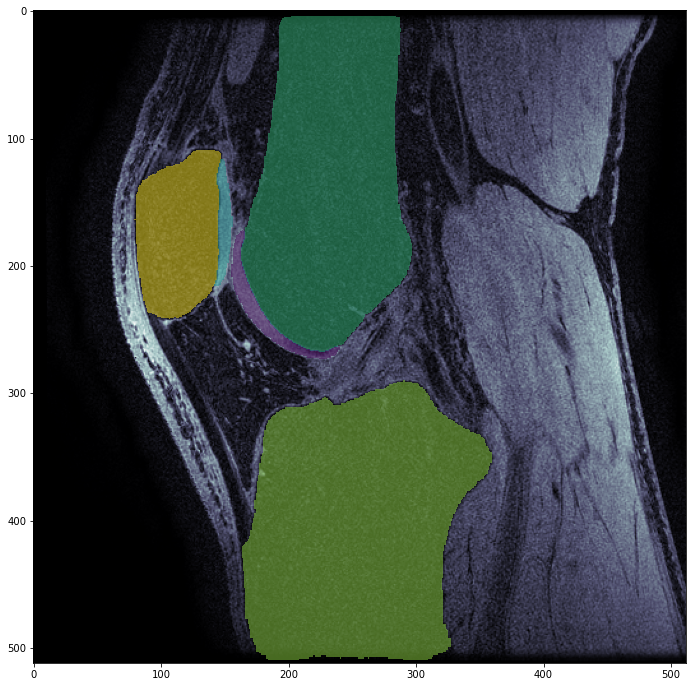

In [5]:
# Set the slice we want to view
slice_idx = 51
# Create a copy of the segmentation array for plotting - set 0s to nan so they are transparent when plotting
seg_array_plotting = np.copy(seg_array).astype(float)
seg_array_plotting[seg_array_plotting == 0] = np.nan

plt.figure(figsize=(12,12))
plt.imshow(image_array[slice_idx, :, :], cmap='bone')
plt.imshow(seg_array_plotting[slice_idx, :, :], alpha=0.5)

### Below cells are for more interactive viewers of segmentations. 
- There are two versions, a simple version and a slightly more intricate version. 
- Either can be used as an example on how to view medical images/segmentations in a jupyter notebook
- If you are OK with the above, feel free to skip these cells

### Simpler Interactive Viewer

In [6]:
from ipywidgets import interact, interactive
import ipywidgets as widgets

plt.figure(figsize=(100, 100))

def f(slice_idx):
    plt.imshow(image_array[slice_idx, :, :], cmap='bone')
    plt.imshow(seg_array_plotting[slice_idx, :, :], alpha=0.5)
    return 

interact(f, slice_idx=widgets.IntSlider(min=0, max=image_array.shape[0], step=1, value=int(image_array.shape[0]/2)));



<Figure size 7200x7200 with 0 Axes>

interactive(children=(IntSlider(value=48, description='slice_idx', max=96), Output()), _dom_classes=('widget-i…

### Less Simple Viewer - ipywidgets

In [7]:

def f(slice_idx, seg_alpha):
    plt.figure(figsize=(10,10))
    plt.imshow(image_array[slice_idx, :, :], cmap='bone')
    plt.imshow(seg_array_plotting[slice_idx, :, :], alpha=seg_alpha)
    plt.show()
    return 

interactive_plot = interactive(
    f, 
    slice_idx=widgets.IntSlider(
        min=0,   
        max=image_array.shape[0]-1, 
        step=1, 
        value=int(image_array.shape[0]/2)),

    seg_alpha=widgets.FloatSlider(min=0,   
        max=1., 
        step=0.1, 
        value=0.5) 
)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(IntSlider(value=48, description='slice_idx', max=95), FloatSlider(value=0.5, description…

# Pre-processing of segmentation before meshing

### Set border of image to be zeros 
- If the segmentation extends all the way to the edges of the image, then it won't be "closed". This means that there will be a big hole in the mesh at the proximal (top) end of the femur, and at the distal (bottom) end of the tibia. 


In [8]:
border_size = 1    # How big do we want the border of background pixels to be.

new_seg_array = np.zeros_like(seg_array)
new_seg_array[border_size:-border_size, border_size:-border_size, border_size:-border_size] = seg_array[border_size:-border_size, border_size:-border_size, border_size:-border_size]

### Create binary / gaussian smoothed masks for each object we want to mesh
- We will create surface meshes from the segmentation using the Marching Cubes algorithm. 
- If you create the mesh directly from the segmentation(s), then there will be a dramatic "staircase" in some of the bones along the slices of the image. 
- To mitigate the "staircasing" there are multiple approaches. Commonly the mesh itself will be 

In [ ]:
def discrete_marching_cubes(vtk_image_reader,
                            n_labels=1,
                            start_label=1,
                            end_label=1,
                            compute_normals_on=True,
                            return_polydata=True
                            ):
    """
    Compute dmc on segmentation image.

    Parameters
    ----------
    vtk_image_reader
    compute_normals_on
    n_contours
    contours_range_start
    contours_range_end

    Returns
    -------

    """
    dmc = vtk.vtkDiscreteMarchingCubes()
    dmc.SetInputConnection(vtk_image_reader.GetOutputPort())
    if compute_normals_on is True:
        dmc.ComputeNormalsOn()
    dmc.GenerateValues(n_labels, start_label, end_label)
    dmc.Update()

    if return_polydata is True:
        return dmc.GetOutput()
    elif return_polydata is False:
        return dmc

def continuous_marching_cubes(vtk_image_reader, 
                              threshold=0.5,
                              compute_normals_on=True,
                              compute_gradients_on=True,
                              return_polydata=True):
    mc = vtk.vtkMarchingContourFilter()
    mc.SetInputConnection(vtk_image_reader.GetOutputPort())
    if compute_normals_on is True:
        mc.ComputeNormalsOn()
    elif compute_normals_on is False:
        mc.ComputeNormalsOff()
    
    if compute_gradients_on is True:
        mc.ComputeGradientsOn()
    elif compute_gradients_on is False:
        mc.ComputeGradientsOff()
    mc.SetValue(0, threshold)
    mc.Update()
    
    if return_polydata is True:
        mesh = mc.GetOutput()
        return mesh
    elif return_polydata is False:
        return mc

def create_surface_mesh_smoothed(seg_image,
                                 label_idx,
                                 image_smooth_var,
                                 loc_tmp_save='/tmp',
                                 tmp_filename='temp_smoothed_bone.nrrd',
                                 copy_image_transform=True,
                                 mc_threshold=0.5):
    """
    Create surface mesh based on a filtered binary image to try and get smoother surface representation
    """
    # Set border of segmentation to 0 so that segs are all closed.
    seg_image = msktimage.set_seg_border_to_zeros(seg_image, border_size=1)

    # smooth/filter the image to get a better surface. 
    filtered_image = msktimage.smooth_image(seg_image, label_idx, image_smooth_var)
    # save filtered image to disk so can read it in using vtk nrrd reader
    sitk.WriteImage(filtered_image, os.path.join(loc_tmp_save, tmp_filename))
    smoothed_nrrd_reader = msktimage.read_nrrd(os.path.join(loc_tmp_save, tmp_filename),
                                               set_origin_zero=True)
    # create the mesh using continuous marching cubes applied to the smoothed binary image. 
    smooth_mesh = continuous_marching_cubes(smoothed_nrrd_reader, threshold=mc_threshold)
    
    if copy_image_transform is True:
        # copy image transofrm to the image to the mesh so that when viewed (e.g. in 3D Slicer) it is aligned with image
        smooth_mesh = meshTransform.copy_image_transform_to_mesh(smooth_mesh, seg_image)

    # Delete tmp files
    safely_delete_tmp_file(loc_tmp_save,
                           tmp_filename)
    return smooth_mesh